## Single model evaluation

This script will evaluate in depth the performance of the best performing models.

In [1]:
# Classifier_cluster
import sys
import xgboost as xgb
import pandas as pd
import os
from itertools import combinations
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy import stats

## Only IDH model

In [2]:
ROI = "whole_tumour" # choose from: ['roi1', 'roi4', 'roi2', 'whole_tumour', 'brain']

all_acquisitions = [
    ["DTI_eddy_FA", "FLAIR", "DWI", "T1_contrast", "DTI_eddy_MD"],
    ["DTI_eddy_FA", "FLAIR", "SWI", "DWI", "T1_contrast", "ASL", "T2"],
    ["DWI", "T1_contrast", "ASL", "T2"],
    ["FLAIR", "SWI", "T1_contrast", "ASL"],
    ["ADC", "DTI_eddy_FA", "DWI", "T1_contrast"],
    ["ADC", "DTI_eddy_FA", "FLAIR", "SWI", "DWI", "T1_contrast"],
    ["ADC", "FLAIR", "DWI", "T1_contrast", "DTI_eddy_MD", "T1"],
    ["ADC", "DTI_eddy_FA", "FLAIR", "SWI", "DWI", "T1_contrast", "ASL", "T2"],
    ["ADC", "DTI_eddy_FA", "SWI", "T1_contrast"],
    ["ADC", "DTI_eddy_FA", "T1_contrast", "ASL"]
]

condition = "with_Sex_with_Age" # choose from: "only_Sex_and_Age" or "no_Sex_no_Age" or "with_Sex_with_Age"
fontsize = 16

def get_paths(acquisitions):
    environment = os.environ.get('PYRADIOMICS_ENV', 'local')  # Default to 'local' if the environment variable is not set
    
    if environment == 'local':
        base_directory = "/Users/Gabriel/MSc_Dissertation/pyRadiomics/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    return base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir

def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    tumour_mapping = {"mutant": 1, "wildtype" :0}
    df["IDH"] = df["IDH"].map(tumour_mapping)

    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes
    if condition == "only_Sex_and_Age":
        X_train = X_train[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_train = X_train.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age

    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    if condition == "only_Sex_and_Age":
        X_validation = X_validation[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_validation = X_validation.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age
    y_validation = validation_target_columns
    
    # Make sure that columns are in same order
    # Strip the "_training" and "_validation" parts from the column names
    X_train_columns_stripped = X_train.columns.str.replace("_training", "")
    X_validation_columns_stripped = X_validation.columns.str.replace("_validation", "")

    # Assert that the modified column names are the same
    assert (X_train_columns_stripped == X_validation_columns_stripped).all(), "The order of the columns in X_train and X_validation is not the same"

    
    return X_train, y_train, X_validation, y_validation

def train_model(X_train, y_train):
    params = {
        "objective": "binary:logistic", # IDH prediction is a binary classification task
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42
    }

    xgb_clf = xgb.XGBClassifier(**params)

    # Fit the model to the IDH column only
    xgb_clf.fit(X_train, y_train["IDH"])
    return xgb_clf

def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred
    
def main():
    results = []

    # This will store the predictions matrix
    predictions_matrix = []

    for single_acquisitions in all_acquisitions:
        
        # Get paths
        base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir = get_paths(single_acquisitions)

        # Load data
        X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

        # Train the model
        clf = train_model(X_train, y_train)

        # Make predictions on the validation set
        y_pred = make_predictions(clf, X_validation)
        
        predictions_matrix.append(y_pred.tolist())

    # Convert list of lists to numpy array for a matrix representation
    predictions_matrix = np.array(predictions_matrix).T
        
    return predictions_matrix, y_validation

matrix, y_validation = main()
print(matrix)



[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1

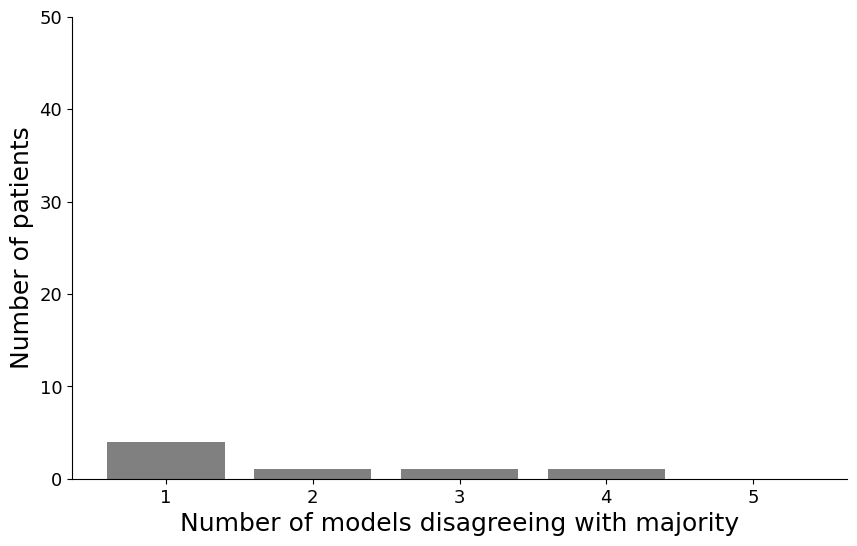

In [6]:
# Set the fontsize variable
fontsize = 18

# Calculate disagreements
disagreements = []
for row in matrix:
    mode = stats.mode(row).mode[0]
    disagreement_count = np.sum(row != mode)
    disagreements.append(disagreement_count)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(disagreements, bins=range(1, 7), align='left', rwidth=0.8, color = 'grey')
plt.xlabel('Number of models disagreeing with majority', fontsize=fontsize)
plt.ylabel('Number of patients', fontsize=fontsize)

# Setting tick label font sizes
plt.xticks(range(1, 6), fontsize=fontsize - 5)
plt.yticks(fontsize=fontsize - 5)

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#plt.axhline(y=49, color='grey', linestyle='--')

# Display settings
plt.ylim(0, 50)

plt.savefig('/Users/Gabriel/Desktop/Jury_disagreement.png', dpi = 300)
plt.show()


In [7]:
row_variances = np.var(matrix, axis=1)

def compute_certainty(x):
    value = 1 / (1 + np.exp(((np.log((1/0.9)-1)) / (-0.25)) * (x-0.25)))
    return round(value, 2)

# Use list comprehension to apply the formula to each value in row_variances
uncertainty_quantification = [compute_certainty(variance) for variance in row_variances]

print(row_variances)

print(uncertainty_quantification)


print('______')

# Convert the matrix to a DataFrame
matrix_df = pd.DataFrame(matrix)

# Compute the mode for each row
majority_vote = matrix_df.mode(axis=1)[0]  # We take the first mode in case there are multiple

# Add the 'Majority Vote' column to the matrix_df DataFrame
matrix_df['Majority Vote'] = majority_vote

# Add the computed values as a new column to the DataFrame
matrix_df['Certainty'] = uncertainty_quantification

# Add the 'IDH' column from y_validation to the matrix dataframe
matrix_df['True Value for IDH'] = y_validation['IDH'].values

print(matrix_df)

[0.   0.   0.24 0.   0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.09 0.   0.
 0.   0.   0.   0.   0.   0.16 0.21]
[0.9, 0.9, 0.52, 0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.69, 0.59]
______
    0  1  2  3  4  5  6  7  8  9  Majority Vote  Certainty  True Value for IDH
0   0  0  0  0  0  0  0  0  0  0              0       0.90                   0
1   0  0  0  0  0  0  0  0  0  0              0       0.90                   0
2   1  1  0  0  1  1  0  1  1  0              1       0.52                   0
3   0  0  0  0  0  0  0  0  0  0              0       0.90                   1
4   0  1  1  1  1  1  1  1  1  1              1       0.80                   1
5   0  0  0  0  0  0  0  0

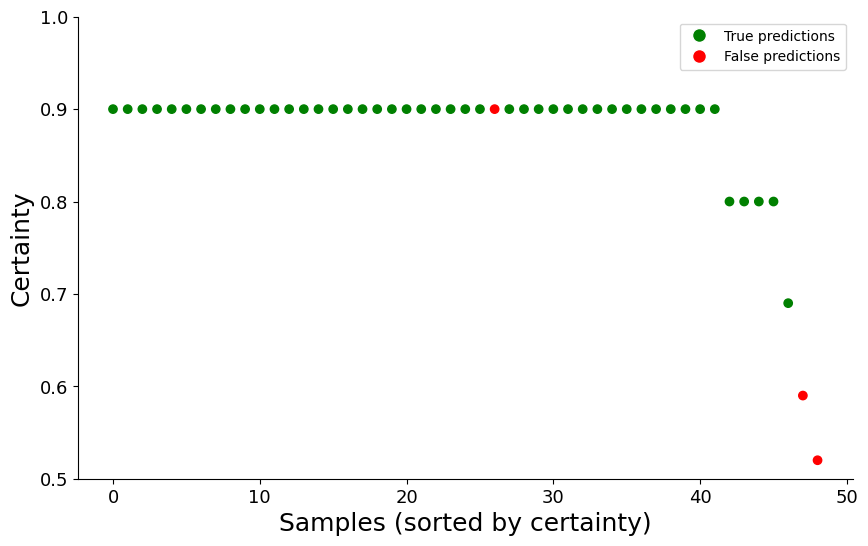

In [9]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D



# Create a copy of matrix_df and sort by 'Certainty'
visualize_matrix = matrix_df.copy()
visualize_matrix.sort_values(by='Certainty', ascending=False, inplace=True)

# Define a color list based on the condition provided
colors = ['green' if (true_value == majority) else 'red' for true_value, majority in zip(visualize_matrix['True Value for IDH'], visualize_matrix['Majority Vote'])]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(visualize_matrix)), visualize_matrix['Certainty'], c=colors)
plt.ylim(0.5, 1)
plt.ylabel('Certainty', fontsize = fontsize)
plt.xlabel('Samples (sorted by certainty)', fontsize = fontsize)
plt.xticks(fontsize=fontsize - 5)
plt.yticks(fontsize=fontsize - 5)
# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='True predictions', markersize=10, markerfacecolor='green'),
                   Line2D([0], [0], marker='o', color='w', label='False predictions', markersize=10, markerfacecolor='red')]
plt.legend(handles=legend_elements)



plt.savefig('/Users/Gabriel/Desktop/Certainty_plot.png', dpi = 300)
plt.show()


## Only WHO output

Class 0:
Sensitivity (Recall): 1.000
Specificity: 0.932
----------
Class 1:
Sensitivity (Recall): 0.200
Specificity: 1.000
----------
Class 2:
Sensitivity (Recall): 0.974
Specificity: 0.900
----------


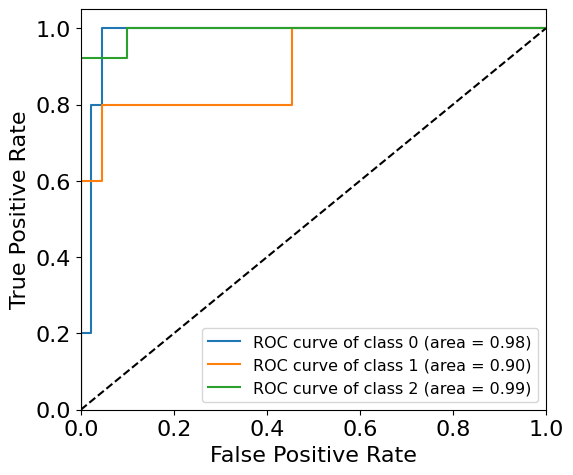

In [5]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

#ROI = "whole_tumour"  
single_acquisitions = ["DTI_eddy_FA", "FLAIR", "DWI","T1_contrast", "DTI_eddy_MD"]

def get_paths(acquisitions):
    environment = os.environ.get('PYRADIOMICS_ENV', 'local')  # Default to 'local' if the environment variable is not set
    
    if environment == 'local':
        base_directory = "/Users/Gabriel/MSc_Dissertation/pyRadiomics/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    elif environment == 'cluster':
        base_directory = "/cluster/project2/UCSF_PDGM_dataset/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    else:
        raise ValueError("Unknown environment: please set PYRADIOMICS_ENV to 'local' or 'cluster'")

    return base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir

def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    tumour_mapping = {"mutant": 1, "wildtype" :0}
    df["IDH"] = df["IDH"].map(tumour_mapping)
    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes
    if condition == "only_Sex_and_Age":
        X_train = X_train[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_train = X_train.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age
    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    if condition == "only_Sex_and_Age":
        X_validation = X_validation[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_validation = X_validation.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age
    y_validation = validation_target_columns
    
    # Make sure that columns are in same order
    # Strip the "_training" and "_validation" parts from the column names
    X_train_columns_stripped = X_train.columns.str.replace("_training", "")
    X_validation_columns_stripped = X_validation.columns.str.replace("_validation", "")

    # Assert that the modified column names are the same
    assert (X_train_columns_stripped == X_validation_columns_stripped).all(), "The order of the columns in X_train and X_validation is not the same"

    #drop IDH
    
    y_train = y_train.drop('IDH', axis=1)
    y_validation = y_validation.drop('IDH', axis=1)

    return X_train, y_train, X_validation, y_validation

def train_model(X_train, y_train):
    params = {
        "objective": "multi:softprob",
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42,
        "num_class": 3
    }

    xgb_clf = xgb.XGBClassifier(**params)
    clf = OneVsRestClassifier(xgb_clf).fit(X_train, y_train)
    return clf

def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def plot_roc_curve(y_test, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(6, 5.2)) # Adjusting figure size
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    plt.legend(loc="lower right", fontsize=11.5)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.savefig(f'/Users/Gabriel/Desktop/WHO_Figure_{ROI}_{condition}.png', dpi=300)
    plt.show()
    
def compute_sensitivity_specificity(y_true, y_score, n_classes=3):
    # Store results
    sensitivity = dict()
    specificity = dict()
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        y_true_binary = (y_true == i).astype(int)  # Convert true values to binary (current class = 1, others = 0)
        y_score_binary = y_score[:, i]  # Get scores for current class
        
        # Threshold at 0.5 for binary predictions
        y_pred_binary = (y_score_binary > 0.5).astype(int)
        
        TP = np.sum((y_pred_binary == 1) & (y_true_binary == 1))
        TN = np.sum((y_pred_binary == 0) & (y_true_binary == 0))
        FP = np.sum((y_pred_binary == 1) & (y_true_binary == 0))
        FN = np.sum((y_pred_binary == 0) & (y_true_binary == 1))
        
        sensitivity[i] = TP / (TP + FN)
        specificity[i] = TN / (TN + FP)

    return sensitivity, specificity

def main():
    results = []
    acquisitions = tuple(single_acquisitions)
    
    # Get paths
    base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir = get_paths(acquisitions)

    # Load data
    X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

    # Binarize the output for multi-label ROC
    lb = LabelBinarizer()
    y_train_bin = lb.fit_transform(y_train)
    y_validation_bin = lb.transform(y_validation)

    # Train the model on 'WHO CNS Grade' only
    clf = train_model(X_train, y_train_bin)

    # Make predictions on the validation set
    y_score = clf.predict_proba(X_validation)
    
    sensitivity, specificity = compute_sensitivity_specificity(np.argmax(y_validation_bin, axis=1), y_score)

    # Display results:
    for i in range(3):
        print(f"Class {i}:")
        print(f"Sensitivity (Recall): {sensitivity[i]:.3f}")
        print(f"Specificity: {specificity[i]:.3f}")
        print("----------")

    # Compute ROC-AUC for each class in 'WHO CNS Grade'
    plot_roc_curve(y_validation_bin, y_score, n_classes=3)

main()


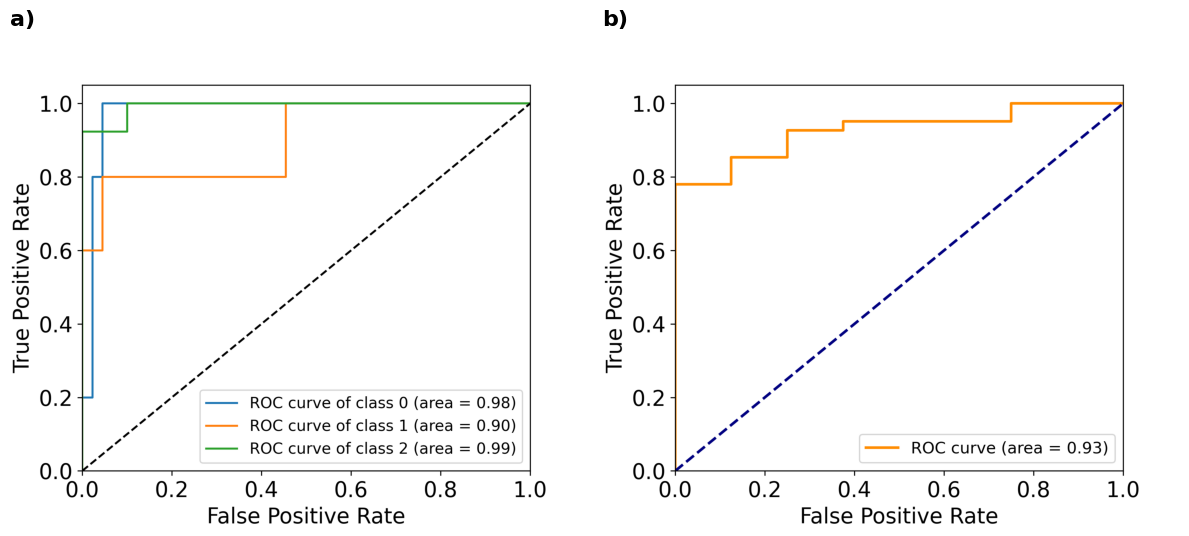

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Load both png figs
fig1 = mpimg.imread(f'/Users/Gabriel/Desktop/WHO_Figure_{ROI}_no_Sex_no_Age.png')
fig2 = mpimg.imread(f'/Users/Gabriel/Desktop/IDH_Figure_{ROI}_no_Sex_no_Age.png')

# Display the images in subplots
axs[0].imshow(fig1)
axs[0].axis('off')
axs[0].annotate("a)", xy=(0, 1), xycoords='axes fraction', fontsize=fontsize, fontweight='bold')

axs[1].imshow(fig2)
axs[1].axis('off')
axs[1].annotate("b)", xy=(0, 1), xycoords='axes fraction', fontsize=fontsize, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig(f'/Users/Gabriel/Desktop/AUCROC_{ROI}_best_model.png', dpi=300)

# Show the figure
plt.show()


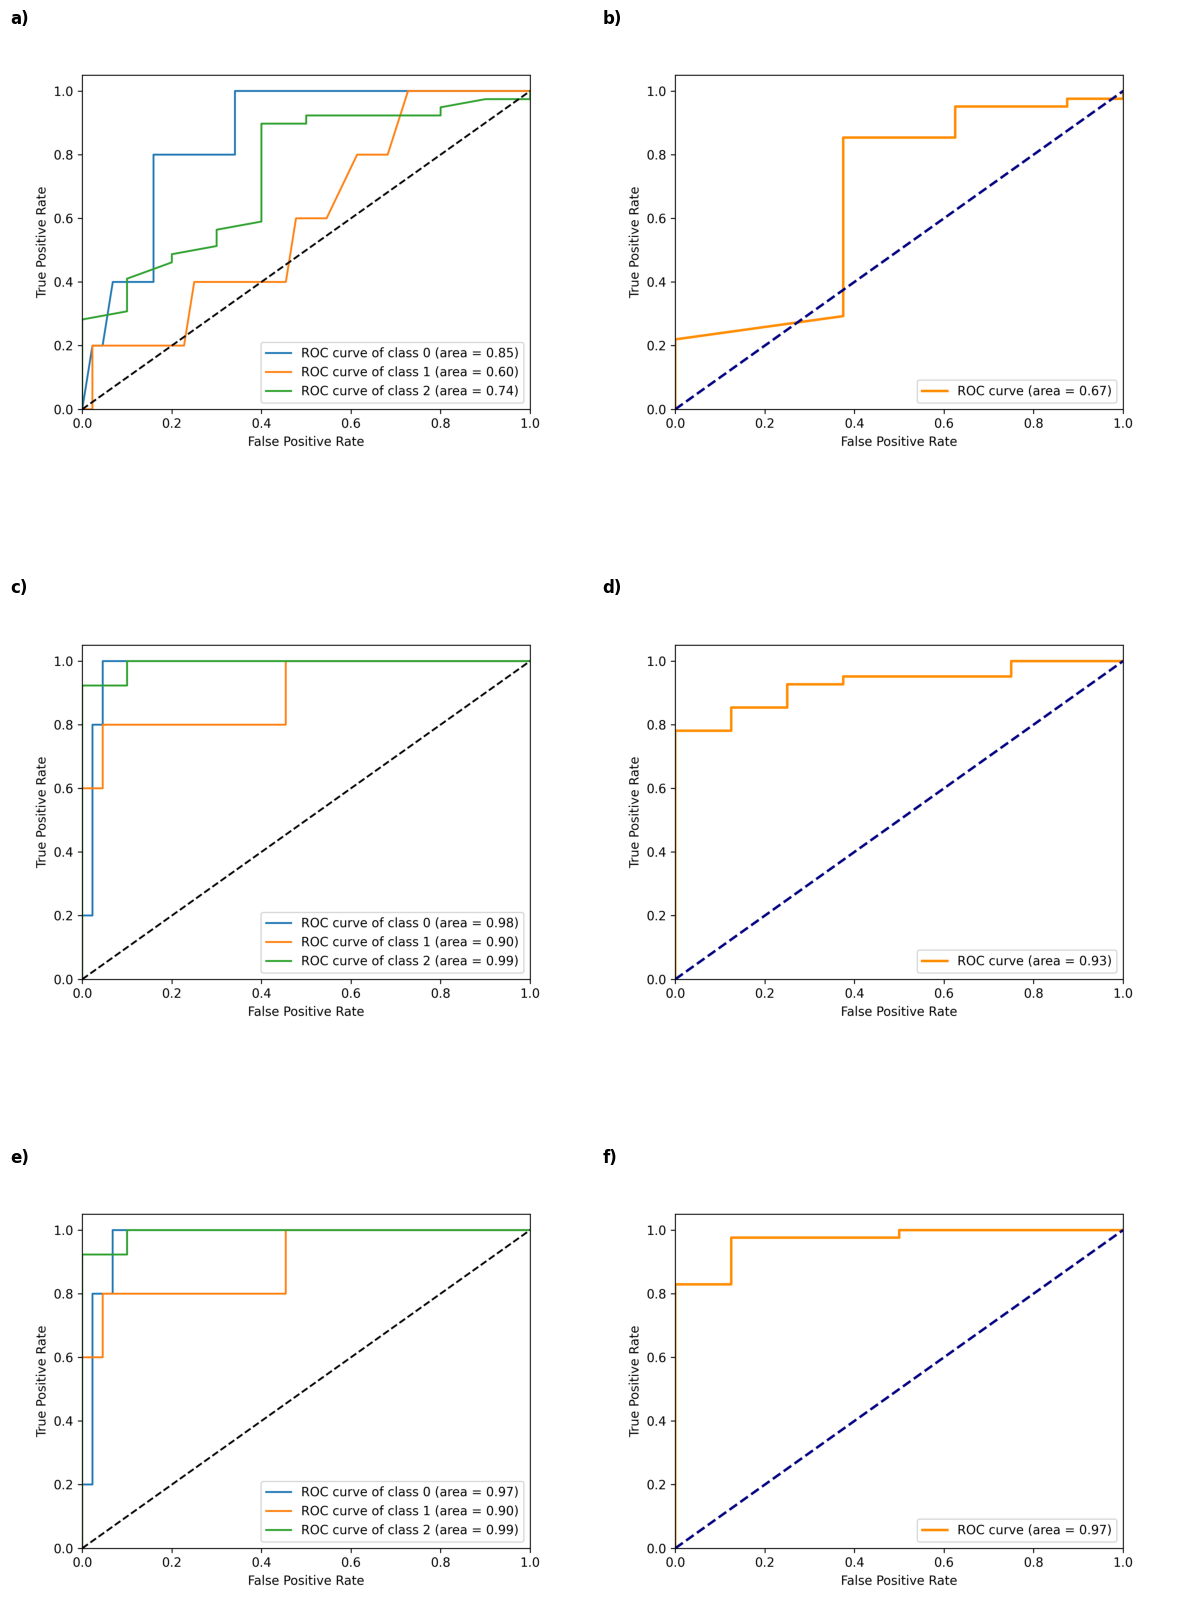

In [32]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Load both png figs
fig1 = mpimg.imread(f'/Users/Gabriel/Desktop/WHO_Figure_{ROI}_only_Sex_and_Age.png')
fig2 = mpimg.imread(f'/Users/Gabriel/Desktop/IDH_Figure_{ROI}_only_Sex_and_Age.png')
fig3 = mpimg.imread(f'/Users/Gabriel/Desktop/WHO_Figure_{ROI}_no_Sex_no_Age.png')
fig4 = mpimg.imread(f'/Users/Gabriel/Desktop/IDH_Figure_{ROI}_no_Sex_no_Age.png')
fig5 = mpimg.imread(f'/Users/Gabriel/Desktop/WHO_Figure_{ROI}_with_Sex_with_Age.png')
fig6 = mpimg.imread(f'/Users/Gabriel/Desktop/IDH_Figure_{ROI}_with_Sex_with_Age.png')

# Display the images in subplots
axs[0, 0].imshow(fig1)
axs[0, 0].axis('off')
axs[0, 0].annotate("a)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

axs[0, 1].imshow(fig2)
axs[0, 1].axis('off')
axs[0, 1].annotate("b)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

axs[1, 0].imshow(fig3)
axs[1, 0].axis('off')
axs[1, 0].annotate("c)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

axs[1, 1].imshow(fig4)
axs[1, 1].axis('off')
axs[1, 1].annotate("d)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

axs[2, 0].imshow(fig5)
axs[2, 0].axis('off')
axs[2, 0].annotate("e)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

axs[2, 1].imshow(fig6)
axs[2, 1].axis('off')
axs[2, 1].annotate("f)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig(f'/Users/Gabriel/Desktop/AUCROC_{ROI}_all.png', dpi=300)

# Show the figure
plt.show()
